## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

VGG19_Weights_path = 'vgg19_weights/vgg19_weights_tf_dim_ordering_tf_kernels.h5'

### SegNet With vgg19 backbone


In [4]:
def _conv_bn_relu(x, filters, kernel_size=1, strides=1):
    x = Conv2D(filters, kernel_size,
                      strides=strides,
                      padding='same',
                      kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

In [5]:
def SegNet(input_shape=None, classes=None, version="SegNet"):
    input_data = Input(shape=input_shape)
    
    # Encoder
    # First convolution block
    conv1_1 = Conv2D(64, kernel_size=(3,3), padding= 'same',
                    activation='relu', name='conv1_1')(input_data)
    conv1_2 = Conv2D(64, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv1_2')(conv1_1)
    maxpool_1 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                            name='maxpool_1')(conv1_2)
    c1 = maxpool_1

    # Second convolution block
    conv2_1 = Conv2D(128, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv2_1')(maxpool_1)
    conv2_2 = Conv2D(128, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv2_2')(conv2_1)
    maxpool_2 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                            name='maxpool_2')(conv2_2)
    c2 = maxpool_2

    # Third convolution block
    conv3_1 = Conv2D(256, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv3_1')(maxpool_2)
    conv3_2 = Conv2D(256, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(256, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv3_3')(conv3_2)
    conv3_4 = Conv2D(256, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv3_4')(conv3_3)
    maxpool_3 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                             name='maxpool_3')(conv3_4)
    c3 = maxpool_3

    # Fourth convolution block
    conv4_1 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv4_1')(maxpool_3)
    conv4_2 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv4_3')(conv4_2)
    conv4_4 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv4_4')(conv4_3)
    maxpool_4 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                             name='maxpool_4')(conv4_4)
    c4 = maxpool_4

    # Fifth convolution block
    conv5_1 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv5_1')(maxpool_4)
    conv5_2 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv5_3')(conv5_2)
    conv5_4 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv5_4')(conv5_3)
    maxpool_5 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                            name='maxpool_5')(conv5_4)
    c5 = maxpool_5

    flatten = Flatten()(maxpool_5)
    fc1 = Dense(4096, activation= 'relu')(flatten)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(4096, activation= 'relu')(drop1)
    drop2 = Dropout(0.5)(fc2)
    output_data = Dense(1000, activation= 'softmax')(drop2)

    vgg = Model(inputs=input_data, outputs=output_data)
    vgg.load_weights(VGG19_Weights_path)
    dropout = True if version == 'Bayesian-SegNet' else False
    
    x = c5
    # Decoder
    if dropout:
        x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = _conv_bn_relu(x, 512, 3, strides=1)
    x = _conv_bn_relu(x, 512, 3, strides=1)
    x = _conv_bn_relu(x, 512, 3, strides=1)

    if dropout:
        x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = _conv_bn_relu(x, 512, 3, strides=1)
    x = _conv_bn_relu(x, 512, 3, strides=1)
    x = _conv_bn_relu(x, 256, 3, strides=1)

    if dropout:
        x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = _conv_bn_relu(x, 256, 3, strides=1)
    x = _conv_bn_relu(x, 256, 3, strides=1)
    x = _conv_bn_relu(x, 128, 3, strides=1)

    if dropout:
        x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = _conv_bn_relu(x, 128, 3, strides=1)
    x = _conv_bn_relu(x, 64, 3, strides=1)

    if dropout:
        x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = _conv_bn_relu(x, 64, 3, strides=1)
    x = tf.keras.layers.Conv2D(num_classes, (3, 3),
             strides=1, padding='same',kernel_initializer='he_normal')(x)
    
    x = tf.keras.layers.Activation('softmax')(x)
    outputs = x
    return tf.keras.models.Model(input_data, outputs, name=version)

    

In [6]:
input_shape = (224, 224, 3)
num_classes = 32
model = SegNet(input_shape, num_classes, version="SegNet")

In [7]:
model.summary()

Model: "SegNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 56, 56, 128)       0    

## Creating custom Image data generators

In [8]:
DATA_PATH = 'data/CamSeq01/'
img_dir = 'data/CamSeq01/'


In [9]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [10]:
label_codes, label_names = zip(*[parse_code(l) for l in open(img_dir+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

([(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)],
 ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building'])

In [11]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [13]:
name2id
id2code

{0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (0, 128, 64),
 4: (128, 0, 0),
 5: (64, 0, 128),
 6: (64, 0, 192),
 7: (192, 128, 64),
 8: (192, 192, 128),
 9: (64, 64, 128),
 10: (128, 0, 192),
 11: (192, 0, 64),
 12: (128, 128, 64),
 13: (192, 0, 192),
 14: (128, 64, 64),
 15: (64, 192, 128),
 16: (64, 64, 0),
 17: (128, 64, 128),
 18: (128, 128, 192),
 19: (0, 0, 192),
 20: (192, 128, 128),
 21: (128, 128, 128),
 22: (64, 128, 192),
 23: (0, 0, 64),
 24: (0, 64, 64),
 25: (192, 64, 128),
 26: (128, 128, 0),
 27: (192, 128, 192),
 28: (64, 0, 64),
 29: (192, 192, 0),
 30: (0, 0, 0),
 31: (64, 192, 0)}

In [11]:
id2name

{0: 'Animal',
 1: 'Archway',
 2: 'Bicyclist',
 3: 'Bridge',
 4: 'Building',
 5: 'Car',
 6: 'CartLuggagePram',
 7: 'Child',
 8: 'Column_Pole',
 9: 'Fence',
 10: 'LaneMkgsDriv',
 11: 'LaneMkgsNonDriv',
 12: 'Misc_Text',
 13: 'MotorcycleScooter',
 14: 'OtherMoving',
 15: 'ParkingBlock',
 16: 'Pedestrian',
 17: 'Road',
 18: 'RoadShoulder',
 19: 'Sidewalk',
 20: 'SignSymbol',
 21: 'Sky',
 22: 'SUVPickupTruck',
 23: 'TrafficCone',
 24: 'TrafficLight',
 25: 'Train',
 26: 'Tree',
 27: 'Truck_Bus',
 28: 'Tunnel',
 29: 'VegetationMisc',
 30: 'Void',
 31: 'Wall'}

In [44]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    num_classes = len(colormap)
    #print(rgb_image.shape) (224, 224, 3)
    shape = rgb_image.shape[:2]+(num_classes,)
    #print(shape) (224, 224, 32)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    #print(encoded_image.shape) (224, 224, 32)
    for i, cls in enumerate(colormap): # pixelwise labeling
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    #print(encoded_image.shape) (224, 224, 32)
    return encoded_image # training labels

def onehot_to_rgb(onehot, colormap = id2code):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2]+(3,))
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [45]:
# Normalizing only images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1


In [46]:
def TrainAugmentGenerator(seed = 1, batch_size = 5):
    train_image_generator = train_frames_datagen.flow_from_directory(
    DATA_PATH + 'train_images/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 5):
    val_image_generator = val_frames_datagen.flow_from_directory(
    DATA_PATH + 'val_images/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [47]:
train = TrainAugmentGenerator()

In [48]:
train
    

<generator object TrainAugmentGenerator at 0x7f44d446dba0>

In [49]:
for i in train:
    print("Shape of input image: ", i[0].shape)
    print("Shape of output mask: ", i[1].shape)
    break

Found 81 images belonging to 1 classes.
Found 81 images belonging to 1 classes.
Shape of input image:  (5, 224, 224, 3)
Shape of output mask:  (5, 224, 224, 32)


## Visualization

Input Image


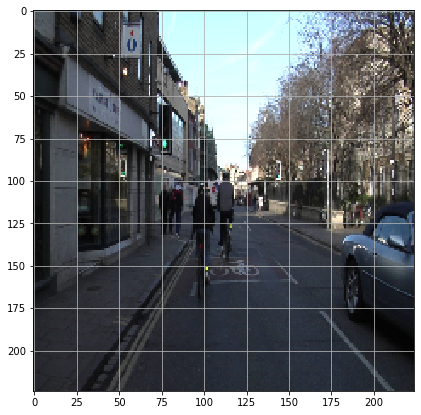

In [50]:
n_images_to_show = 5
for i in train:
    image = i[0][0]
    image = np.array(image * 255, np.int32)

    #Plot the corresponding frames and masks
    fig = plt.figure(figsize=(20,7))
    fig.add_subplot(1,2,1)
    plt.grid(b=None)
    print("Input Image")
    plt.imshow(image)
    plt.show()
    break
    

## Dice Coefficient

In [53]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [54]:
smooth = 1.

In [55]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[dice_coef,'accuracy'])

In [56]:
tensorboard = TensorBoard(log_dir='logs', write_graph=True)
checkpoint = ModelCheckpoint(mode='max', filepath='camvid_model_vgg19_segnet_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
early_stopping = EarlyStopping(mode='min', monitor='val_loss', patience=50, verbose=1)
callbacks = [tensorboard, checkpoint, early_stopping]

In [57]:
batch_size = 5
steps_per_epoch = np.ceil(float(81 - round(0.2*81)) / float(batch_size))
steps_per_epoch

13.0

In [58]:
validation_steps = (float((round(0.2*20))) / float(batch_size))
validation_steps

0.8

In [25]:
num_epochs = 1

In [26]:
result = model.fit(TrainAugmentGenerator(), steps_per_epoch=steps_per_epoch ,
                validation_data = ValAugmentGenerator(), 
                validation_steps = validation_steps, epochs=num_epochs, callbacks=callbacks, verbose=1)

Found 81 images belonging to 1 classes.
Found 81 images belonging to 1 classes.
13/13 [==============================] - ETA: 0s - loss: 1.6721 - dice_coef: 0.5533 - accuracy: 0.5483 Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.

Epoch 00001: accuracy improved from -inf to 0.54827, saving model to camvid_model_vgg19_segnet_checkpoint.h5
13/13 [==============================] - 191s 15s/step - loss: 1.6721 - dice_coef: 0.5533 - accuracy: 0.5483 - val_loss: 11.8363 - val_dice_coef: 0.2445 - val_accuracy: 0.2416


## Alternative 

In [59]:
def SegNet(input_shape=None, classes=None):
    input_data = Input(shape=input_shape)

    # First convolution block
    conv1_1 = Conv2D(64, kernel_size=(3,3), padding= 'same',
                    activation='relu', name='conv1_1')(input_data)
    conv1_2 = Conv2D(64, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv1_2')(conv1_1)
    maxpool_1 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                            name='maxpool_1')(conv1_2)
    c1 = maxpool_1

    # Second convolution block
    conv2_1 = Conv2D(128, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv2_1')(maxpool_1)
    conv2_2 = Conv2D(128, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv2_2')(conv2_1)
    maxpool_2 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                            name='maxpool_2')(conv2_2)
    c2 = maxpool_2

    # Third convolution block
    conv3_1 = Conv2D(256, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv3_1')(maxpool_2)
    conv3_2 = Conv2D(256, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(256, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv3_3')(conv3_2)
    conv3_4 = Conv2D(256, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv3_4')(conv3_3)
    maxpool_3 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                             name='maxpool_3')(conv3_4)
    c3 = maxpool_3

    # Fourth convolution block
    conv4_1 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv4_1')(maxpool_3)
    conv4_2 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv4_3')(conv4_2)
    conv4_4 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv4_4')(conv4_3)
    maxpool_4 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                             name='maxpool_4')(conv4_4)
    c4 = maxpool_4

    # Fifth convolution block
    conv5_1 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv5_1')(maxpool_4)
    conv5_2 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv5_3')(conv5_2)
    conv5_4 = Conv2D(512, kernel_size=(3,3), padding= 'same',
                    activation= 'relu', name='conv5_4')(conv5_3)
    maxpool_5 = MaxPooling2D(pool_size=(2,2), strides= (2,2),
                            name='maxpool_5')(conv5_4)
    c5 = maxpool_5

    flatten = Flatten()(maxpool_5)
    fc1 = Dense(4096, activation= 'relu')(flatten)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(4096, activation= 'relu')(drop1)
    drop2 = Dropout(0.5)(fc2)
    output_data = Dense(1000, activation= 'softmax')(drop2)

    vgg = Model(inputs=input_data, outputs=output_data)
    vgg.load_weights(VGG19_Weights_path)
    
    o = ( ZeroPadding2D( (1,1) , data_format='channels_last' ))(c4)
    o = ( Conv2D(512, (3, 3), padding='valid', data_format='channels_last'))(o)
    o = ( BatchNormalization())(o)
    
    o = ( UpSampling2D( (2,2), data_format='channels_last'))(o)
    o = ( ZeroPadding2D( (1,1), data_format='channels_last'))(o)
    o = ( Conv2D( 512, (3, 3), padding='valid', data_format='channels_last'))(o)
    o = ( BatchNormalization())(o)
    
    o = ( UpSampling2D( (2,2), data_format='channels_last'))(o)
    o = ( ZeroPadding2D( (1,1), data_format='channels_last'))(o)
    o = ( Conv2D( 256, (3, 3), padding='valid', data_format='channels_last'))(o)
    o = ( BatchNormalization())(o)

    o = ( UpSampling2D((2,2)  , data_format='channels_last' ) )(o)
    o = ( ZeroPadding2D((1,1) , data_format='channels_last' ))(o)
    o = ( Conv2D( 128 , (3, 3), padding='valid' , data_format='channels_last' ))(o)
    o = ( BatchNormalization())(o)

    o = ( UpSampling2D((2,2)  , data_format='channels_last' ))(o)
    o = ( ZeroPadding2D((1,1)  , data_format='channels_last' ))(o)
    o = ( Conv2D( 64 , (3, 3), padding='valid'  , data_format='channels_last' ))(o)
    o = ( BatchNormalization())(o)
    
    o =  Conv2D(classes , (3, 3) , padding='same', data_format='channels_last' )( o )
    o = (Activation('softmax'))(o)
    model = Model(input_data , o)
    

In [60]:
model = SegNet((224, 224, 3), 32)

In [51]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[dice_coef,'accuracy'])

In [37]:
result = model.fit(TrainAugmentGenerator(), steps_per_epoch=steps_per_epoch ,
                validation_data = ValAugmentGenerator(), 
                validation_steps = validation_steps, epochs=num_epochs, callbacks=callbacks, verbose=1)

Found 81 images belonging to 1 classes.
Found 81 images belonging to 1 classes.
13/13 [==============================] - ETA: 0s - loss: 1.8633 - dice_coef: 0.5497 - accuracy: 0.5640 Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.

Epoch 00001: accuracy improved from 0.54827 to 0.56400, saving model to camvid_model_vgg19_segnet_checkpoint.h5
13/13 [==============================] - 243s 19s/step - loss: 1.8633 - dice_coef: 0.5497 - accuracy: 0.5640 - val_loss: 10.7225 - val_dice_coef: 0.3146 - val_accuracy: 0.3105


## Evaluation

In [53]:
testing_gen = ValAugmentGenerator()

In [54]:
batch_img,batch_mask = next(testing_gen)
preds = model.predict(batch_img)
np.shape(preds)

Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


(5, 224, 224, 32)

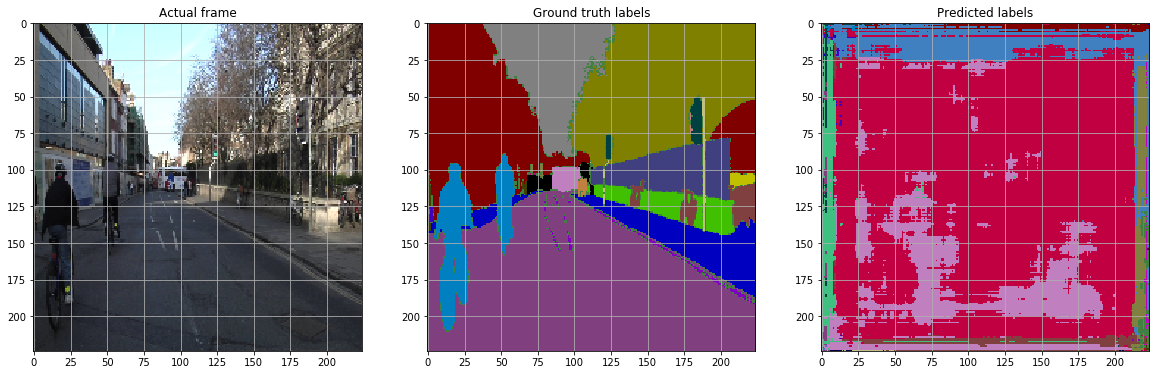

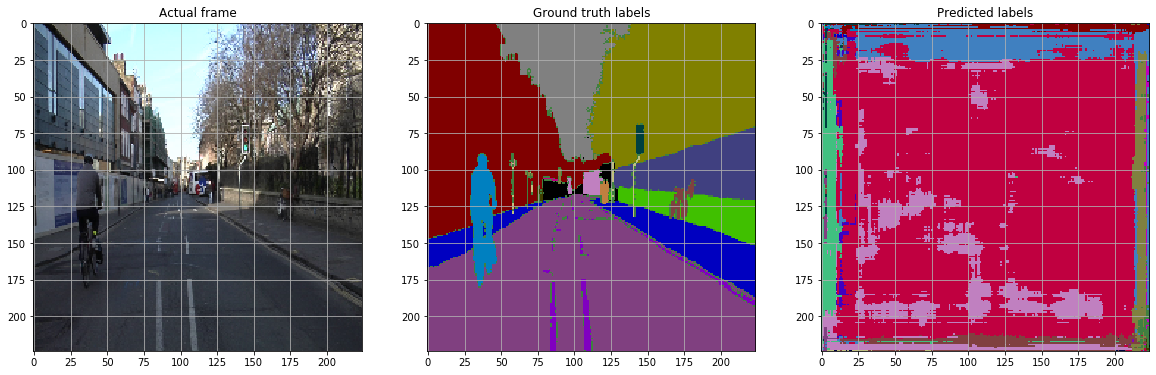

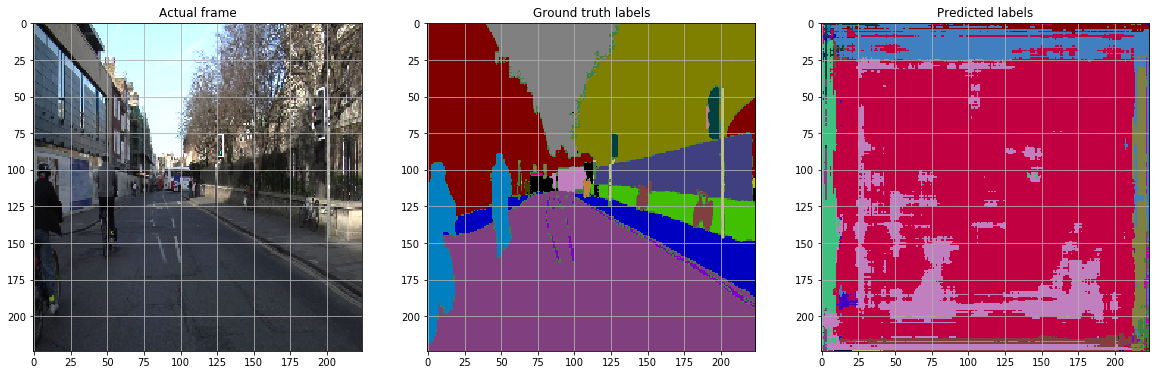

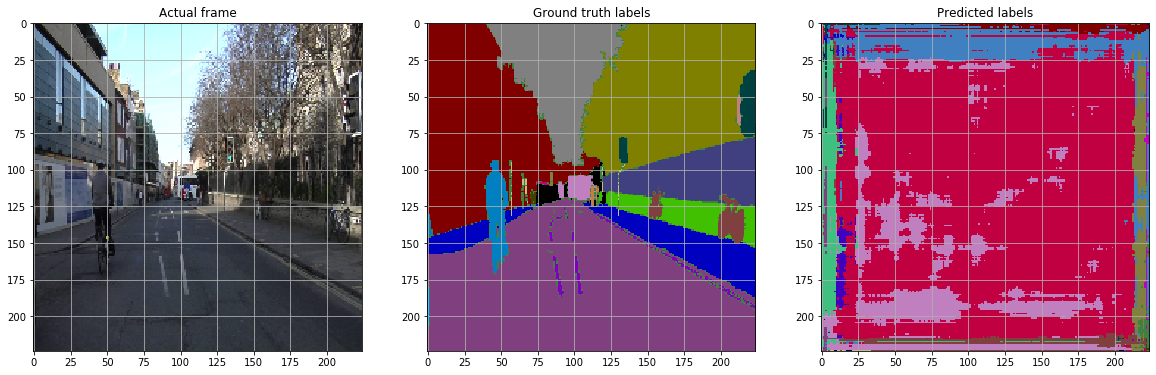

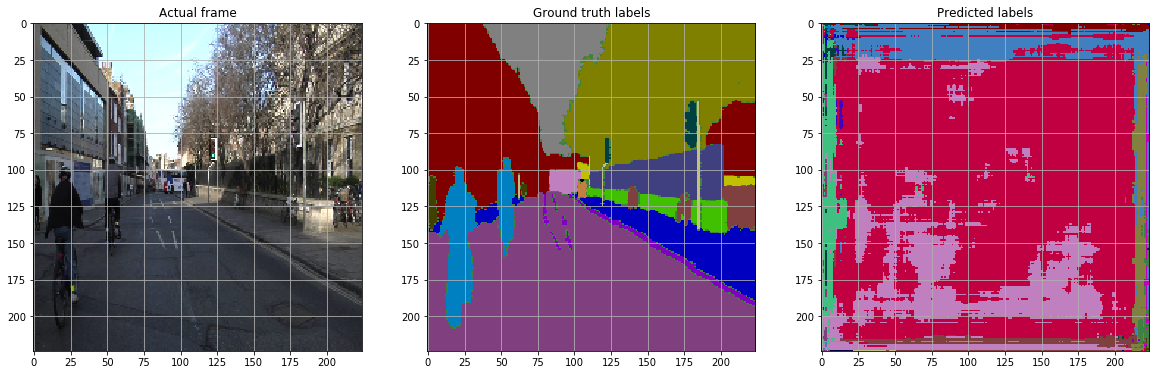

In [56]:
for i in range(0,np.shape(preds)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(preds[i],id2code))
    ax3.grid(b=None)
    
    plt.show()